## Imports

In [21]:
# Required Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

from joblib import dump

In [22]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/MaxTechniche/BuildWeek2/main/model/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = 'model/'
    
top_1000 = 'top_1000.csv'

In [23]:
from category_encoders import OrdinalEncoder, OneHotEncoder

In [24]:
df = pd.read_csv(DATA_PATH+top_1000)

## Wrangling

In [25]:
def genres(df):
    """Manual OneHotEncoding of genres"""
    df = df.copy() 
    
    # Grab genres
    genres = set()
    for item in df['Genres']:
        item = item.lstrip("['").rstrip("']").replace("'","").split(', ')
        for genre in item:
            genres.add(genre)

    # Create generic encoded genre columns
    df[list(genres)] = 0
        
    # Set genre to 1 if contained
    for i, item in zip(df.index, df['Genres']):
        item = item.lstrip("['").rstrip("']").replace("'","").split(', ')
        for genre in item:
            df.at[i, genre] = 1
        
    return df

def merge_certifications(df):
    df = df.copy()

    # Create rating mapping
    mapping = {
        'TV-PG':'PG',
        'TV-MA':'R',
        'TV-14':'PG-13',
        'M':'PG-13',
        'GP':'PG',
        'Unrated|Not Rated|Passed|Approved': np.NaN
    }

    # Apply rating mapping
    df['Certification'] = df['Certification'].replace(mapping, regex=True)

    return df

def wrangle(df):
    """Basic wrangle. Calls other 'wrangle' functions. Drops unneccesarry/unwanted columns. Also feature engineering"""
    df = df.copy()

    df = genres(df)
    # df = merge_certifications(df)

    df['Description Length'] = df['Description'].apply(lambda x: len(x))

    df = df.drop(columns=['Placement', 'Genres', 'Description', 'Directors', 'stars', 'Title'])

    return df

df = wrangle(df)

## Modeling

### Regression (RandomForestRegressor)

In [26]:
target = 'Runtime'

In [27]:
reg_df = df.copy()
if reg_df[target].isna().sum():
    reg_df = reg_df.dropna(subset=[target])
reg_X = reg_df.drop(columns=target)
reg_y = reg_df[target]

reg_X_train, reg_X_val, reg_y_train, reg_y_val = train_test_split(reg_X, reg_y, test_size=.2, random_state=42)

In [28]:
%%capture
reg_pipeline = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(),
    Ridge(random_state=42, fit_intercept=True)
)

In [29]:
reg_params = {
    'ridge__alpha': np.arange(.1, 100.1, .1),
    'ridge__solver': ['lsqr', 'sparse_cg']
}

reg = GridSearchCV(
    reg_pipeline,
    param_grid=reg_params,
    n_jobs=6,
    cv=5
)
reg.fit(reg_X_train, reg_y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('standardscaler', StandardScaler()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('ridge', Ridge(random_state=42))]),
             n_jobs=6,
             param_grid={'ridge__alpha': array([  0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,   0.8,   0.9,
         1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,   1.7,   1.8,
         1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,   2.6,   2.7,
         2.8,   2.9,   3. ,   3.1,   3...
        93.7,  93.8,  93.9,  94. ,  94.1,  94.2,  94.3,  94.4,  94.5,
        94.6,  94.7,  94.8,  94.9,  95. ,  95.1,  95.2,  95.3,  95.4,
        95.5,  95.6,  95.7,  95.8,  95.9,  96. ,  96.1,  96.2,  96.3,
        96.4,  96.5,  96.6,  96.7,  96.8,  96.9,  97. ,  97.1,  97.2,
        97.3,  97.4,  97.5,  97.6,  97.7,  97.8,  97.9,  98. ,  98.1,
        98

In [13]:
dump(reg, 'model/ridge.joblib', compress=True)

['model/ridge.joblib']

In [23]:
baseline = mean_absolute_error(reg_y_train, [reg_y_train.mean()]*len(reg_y_train))
print('Baseline MAE:', baseline)
print('Regression MAE:', mean_absolute_error(reg_y_val, reg.predict(reg_X_val))) # 8.9
print('Regression R2/Score:', reg.score(reg_X_val, reg_y_val))


Baseline MAE: 20.224874999999997
Regression MAE: 19.92124184313618
Regression R2/Score: 0.2450102693355659


There's very little reason to determine the runtime of a movie, but if we can use features that we want to see, we can then determine how long the runtime should be to have a better chance at acheiving other things. (possibly)

### Classification (LogisticRegression)

In [14]:
target = 'Certification'

In [15]:
class_df = df.copy()
if class_df[target].isna().sum():
    class_df = class_df.dropna(subset=[target])
class_X = class_df.drop(columns=target)
class_y = class_df[target]

class_X_train, class_X_val, class_y_train, class_y_val = train_test_split(class_X, class_y, test_size=.2, random_state=42)

In [16]:
class_pipeline = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_jobs=6, random_state=42)
)

In [17]:
class_params = {
    'randomforestclassifier__n_estimators': range(100, 5001, 100),
    'randomforestclassifier__max_depth': range(8, 31, 2),
    'randomforestclassifier__max_samples': np.arange(.2, .81, .05)
}

class_model = RandomizedSearchCV(
    class_pipeline,
    param_distributions=class_params,
    n_jobs=6,
    cv=5,
    random_state=42,
    verbose=1
)
class_model.fit(class_X_train, class_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.3min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=6,
                                                                     random_state=42))]),
                   n_jobs=6,
                   param_distributions={'randomforestclassifier__max_depth': range(8, 31, 2),
                                        'randomforestclassifier__max_samples': array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 ]),
                                        'randomforestclassifier__n_estimators': range(100, 5001, 10

In [20]:
dump(class_model, 'model/class.joblib', compress=True)

['model/class.joblib']

In [18]:
class_baseline = class_y_train.value_counts(normalize=True).max()

print('Class Runtime Baseline Accuracy:', class_baseline)
print('Class Runtime Model Accuracy:', class_model.score(class_X_val, class_y_val))


Class Runtime Baseline Accuracy: 0.39847715736040606
Class Runtime Model Accuracy: 0.5888324873096447


Using the `merge_certifications` function generalizes the certifications of the group of movies. Leaving this out increases the accuracy of the `ridge` model but 'decreases' the accuracy of the `randomforestclassifier`. The reason for that is there's more for the ridge model to look at for determining runtime, but the classifier now has to determine from more than twice as many certifications.

In [67]:
import matplotlib.pyplot as plt

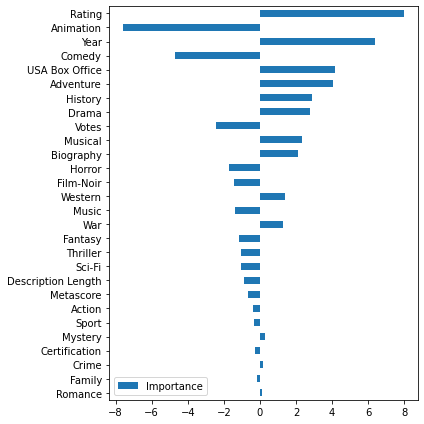

In [89]:
fig, ax = plt.subplots(figsize=(6, 6))
pd.DataFrame(index=reg_X_val.columns, data=reg_pipeline.named_steps['ridge'].coef_, columns=['Importance']).sort_values('Importance', key=lambda x: abs(x)).plot.barh(ax=ax)
plt.tight_layout()
fig.savefig('assets/ridge_importance.jpg', dpi=300)